In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [2]:
import torch
from torch import nn
import PIL
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

In [3]:
assert torch.__version__=='1.8.1'

In [19]:
trainset = datasets.MNIST('digit_MNIST_data/', download = True, train = True, transform = transforms.ToTensor())
testset = datasets.MNIST('digit_MNIST_data/', download = True, train = False, transform = transforms.ToTensor())

0it [00:00, ?it/s]

Extracting digit_MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

Extracting digit_MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz


0it [00:00, ?it/s]

Extracting digit_MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz


0it [00:00, ?it/s]

Extracting digit_MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...


/Users/Torgeir/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:335: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1616554845587/work/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed).view(length, num_rows, num_cols)


Done!


In [4]:
np.random.seed(0)
torch.manual_seed(0)

In [12]:
class FashionNeihgborhoodData(Dataset):

    def __init__(self, image_dir, transform=False, nbh_size=(5,11)):#csv_file,root,
        #self.root = root
        self.image_dir = image_dir
        #self.image_files = os.listdir(image_dir)
        #self.data = pd.read_csv(csv_file).iloc[:, 1]
        self.fashion_data = torch.load(image_dir)
        self.fashion_imgs = self.fashion_data[0]/255
        self.fashion_labels = self.fashion_data[1]
        self.transform = transform
        self.nbh_size = nbh_size

    def __len__(self):
        return self.fashion_labels.shape[0]

    def __getitem__(self, index):
        #image_name = os.path.join(self.image_dir, self.image_files[index])  
        #image = PIL.Image.open(image_name)
        image = self.fashion_imgs[index]
        #label = self.data[index]
        if self.transform:
            image = self.transform(image)
        
        nbh_im = torch.empty((0,50)) 
        for i in range(20):
            #x1 = np.random.randint(0, images[1].shape[1]-self.nbh_size[0]-1)
            #y1 = np.random.randint(0, images[1].shape[2]-self.nbh_size[1]-1)
            x1 = np.random.randint(0, image.shape[0]-self.nbh_size[0]-1)
            y1 = np.random.randint(0, image.shape[1]-self.nbh_size[1]-1)
            
            x2, y2 = x1+self.nbh_size[0], y1+self.nbh_size[1]
            nbh = torch.flatten(image[x1:x2,y1:y2])
            nbh = nbh[:50]
            nbh_im = torch.cat((nbh_im, nbh.unsqueeze(0)), dim = 0)
        
        return nbh_im#image #, label)

In [13]:
class MLP_Mix(nn.Module):#define neighborhood size
    '''
    Multilayer Perceptron.
    '''
    def __init__(self, first_layer_size, num_mixtures):
        super().__init__()
        self.first_layer_size = first_layer_size
        self.num_mixtures = num_mixtures
        self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(self.first_layer_size, 100),
        nn.ReLU(),
        #nn.LeakyReLU(),
        nn.Linear(100, 100),
        nn.ReLU(),
        #nn.LeakyReLU(),
        nn.Linear(100, 100),
        nn.ReLU(), ## leaky relu
        #nn.LeakyReLU(),
        nn.Linear(100, 100),
        nn.ReLU(), ## leaky relu
        nn.Linear(100, 3*self.num_mixtures),#,
        #nn.ReLU()
        #nn.Sigmoid()
        
        )
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):
        '''Forward pass'''
        out = self.layers(x)

        softplus = nn.Softplus()
        sigmoid = nn.Sigmoid()

        mu = torch.reshape(out[:,0:self.num_mixtures],(out.shape[0],self.num_mixtures))
        mu1 = torch.reshape(mu[:,0],  (out.shape[0], 1))
        mu2 = mu1 + torch.reshape(softplus(mu[:,1]), (out.shape[0], 1))
        mu = torch.cat((mu1,mu2), dim=1)
        mu = sigmoid(mu) #- 0.5

        sig = torch.reshape(softplus(out[:,1*self.num_mixtures:2*self.num_mixtures]),(out.shape[0],self.num_mixtures)) #sig squared
        sig = torch.clamp(sig, 0.00000001)

        pi_mix = torch.reshape(out[:,2*self.num_mixtures:3*self.num_mixtures],(out.shape[0],self.num_mixtures))
        pi_mix = self.softmax(pi_mix)

        out = torch.cat((mu,sig,pi_mix),dim=1)

        return out

In [14]:
def Mixture_Gauss_NLLLoss(target, pred):# mu, sigma, pi_mix):
    total_lik = 0
    loss_func  = nn.GaussianNLLLoss(full=False, reduction='none')

    nr_mix = int(pred.shape[1]/3)

    mu = pred[:,0:nr_mix]
    sigma_sq = pred[:,nr_mix:2*nr_mix]  #sigma2 
    pi_mix = pred[:,2*nr_mix:3*nr_mix]  

    sigma_sq = torch.clamp(sigma_sq, 0.00000001)
    for i in range(nr_mix):

        loss = loss_func(mu[:,i], target, sigma_sq[:,i])
        likelihood = torch.exp(-loss)
        
        total_lik += pi_mix[:,i]*likelihood

    
    gauss_mix_loss = torch.log(torch.clamp(total_lik, min=0.00000001))
   
    return -gauss_mix_loss.mean()  #torchmean

In [21]:
MNIST_train = FashionNeihgborhoodData(image_dir='digit_MNIST_data/MNIST/processed/training.pt')
MNIST_test = FashionNeihgborhoodData(image_dir='digit_MNIST_data/MNIST/processed/test.pt')

In [27]:
mlp_mix = MLP_Mix(first_layer_size=49, num_mixtures=2)

# Define the loss function and optimizer
loss_function  = Mixture_Gauss_NLLLoss

#optimizer = torch.optim.SGD(mlp_mix.parameters(), lr=0.001)
#lr_scheduler = 
optimizer = torch.optim.Adam(mlp_mix.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)

In [28]:
dataloader_train = DataLoader(MNIST_train, batch_size=20,
                        shuffle=True)#, num_workers=0)

dataloader_test = DataLoader(MNIST_test, batch_size=20,
                        shuffle=True)

In [29]:
epochs = 100 #20
loss_vals_train = []
loss_vals_test = []

In [30]:
for e in range(epochs): 
    
    print(f'Starting epoch {e+1}')
    
    # Set current loss value
    current_loss = 0.0
    
    for i, data in enumerate(dataloader_train, 0):
        
        #current_loss = 0.0
      # Get and prepare inputs
        data = torch.reshape(data,(-1,50))
        inputs, targets = data[:,:-1], data[:,-1]
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))
      
      # Zero the gradients
        optimizer.zero_grad()
      
      # Perform forward pass
        outputs = mlp_mix(inputs)
        
      # Compute loss
        
        loss = loss_function(targets, outputs)#mu_s, sigma_s, pi_mix)
      
      # Perform backward pass
        loss.backward()
      
      # Perform optimization
        optimizer.step()
      
      # Print statistics
        current_loss += loss.item()
        
        #if i % 500 == 0:
        #if i % 20 == 0:
    scheduler.step()

    print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / len(dataloader_train)))
    #current_loss = 0.0

    validation_loss = 0.0
    mlp_mix.eval()

    for i, data in enumerate(dataloader_test, 0):

        data = torch.reshape(data,(-1,50))
        inputs, targets = data[:,:-1], data[:,-1]
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        outputs = mlp_mix(inputs)

        loss_val = loss_function(targets, outputs)# mu_s, sigma_s, pi_mix)

        validation_loss += loss_val.item()


    print('Val Loss after mini-batch %5d: %.3f' %
                (i + 1, validation_loss / len(dataloader_test)))
  # Process is complete.
    loss_vals_train.append(current_loss/len(dataloader_train))
    loss_vals_test.append(validation_loss/len(dataloader_test))

print('Training process has finished.')

Starting epoch 1
Loss after mini-batch  3000: -4.114
Val Loss after mini-batch   500: -4.762
Starting epoch 2
Loss after mini-batch  3000: -4.853
Val Loss after mini-batch   500: -4.898
Starting epoch 3
Loss after mini-batch  3000: -4.913
Val Loss after mini-batch   500: -4.929
Starting epoch 4
Loss after mini-batch  3000: -4.943
Val Loss after mini-batch   500: -4.940
Starting epoch 5
Loss after mini-batch  3000: -4.956
Val Loss after mini-batch   500: -4.959
Starting epoch 6
Loss after mini-batch  3000: -4.965
Val Loss after mini-batch   500: -4.977
Starting epoch 7
Loss after mini-batch  3000: -4.980
Val Loss after mini-batch   500: -4.982
Starting epoch 8
Loss after mini-batch  3000: -4.983
Val Loss after mini-batch   500: -4.991
Starting epoch 9
Loss after mini-batch  3000: -4.988
Val Loss after mini-batch   500: -4.995
Starting epoch 10
Loss after mini-batch  3000: -4.996
Val Loss after mini-batch   500: -4.996
Starting epoch 11
Loss after mini-batch  3000: -5.003
Val Loss after 

In [31]:
torch.save(mlp_mix.state_dict(), 'FCNN_mnist_model.pt')

Text(0.5, 1.0, 'loss')

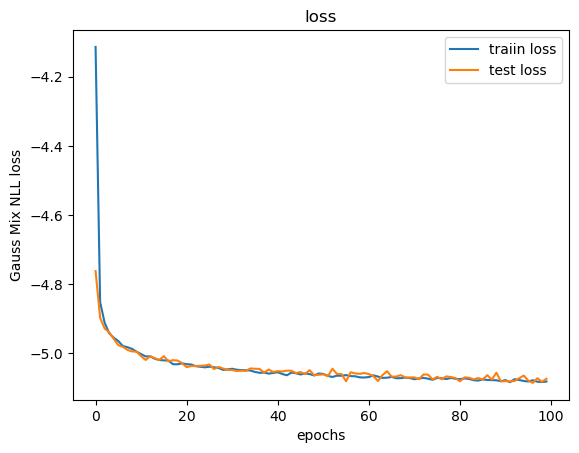

In [48]:
plt.plot(range(len(loss_vals_train)),loss_vals_train, label='traiin loss')
plt.plot(range(len(loss_vals_test)),loss_vals_test, label='test loss')
plt.xlabel('epochs')
plt.ylabel('Gauss Mix NLL loss')
plt.legend()
plt.savefig('../figures/MNIST_FCNN_loss_plot.jpg')
plt.title('loss')

In [135]:
def gen_im_mix(model, new_img, nbh_size):#im_size, nbh_size):
    m, n = nbh_size
    
    im_size = new_img.shape
    #new_im = torch.rand(im_size)-0.5 # prøv med 0.5
    #new_im = torch.full(im_size,0.5)
    new_im = new_img.clone()
    pred_mu = np.zeros(im_size)
    pred_sigma2 = np.zeros(im_size)
    pred_mu2 = np.zeros(im_size)
    pred_sigma2_2 = np.zeros(im_size)
    pred_pi_mix = np.zeros(im_size)
    
    #new_im = fashion_imgs_test[0][2]/255 - 0.5
    #new_im = new_im.numpy()
    
    for i in range(10, new_im.shape[0]):
        for j in range(n, new_im.shape[1]-n):
            
            neighborhood = new_im[i-m:i,j-n:(j+n+1)]
            flat_n = neighborhood.flatten()
            
            dlt = n
            
            nbh_ij = flat_n[:-(dlt+1)]
            
            output = model(torch.reshape(nbh_ij,(1,49))).detach().numpy()

            #pi_mix_output = output[0,2]
            #mu_output = output[0,0]
            #sigma2_output = output[0,1]
            #print(sigma2_output)
            nr_mix = int(output.shape[1]/3)

            pi_mix_output = output[0,2*nr_mix:]
            mu_output = output[0,0:nr_mix]
            sigma2_output = output[0,nr_mix:2*nr_mix]
            #print(pi_mix_output)
            
            pi_mix_sample = np.random.choice(nr_mix, 1, p=pi_mix_output)[0]
            #pi_mix_sample = 0
            
            #sample = np.random.normal(output.detach().numpy()[0,0],np.sqrt(np.abs(output.detach().numpy()[0,1])))
            sample = np.random.normal(mu_output[pi_mix_sample], np.sqrt(sigma2_output[pi_mix_sample]))
            #sample = np.random.normal(mu_output, np.sqrt(sigma2_output))
            
            sample = np.clip(sample, 0.0, 1.0)
            #new_im[i,j] = sample

            #new_im[i,j] = torch.from_numpy(mu_output)[pi_mix_sample]

            #pred_mu[i,j] = mu_output[pi_mix_sample]
            #pred_sigma2[i,j] = sigma2_output[pi_mix_sample]
            pred_mu[i,j] = mu_output[0]
            pred_sigma2[i,j] = sigma2_output[0]

            pred_mu2[i,j] = mu_output[1]
            pred_sigma2_2[i,j] = sigma2_output[1]
            pred_pi_mix[i,j] = pi_mix_output[0]
    
    #return new_im, pred_mu, pred_sigma2
    return new_im, pred_mu, pred_mu2, pred_sigma2, pred_sigma2_2, pred_pi_mix

In [133]:
new_im, pred_mu, pred_mu2, pred_sigma2, pred_sigma2_2, pred_pi_mix = gen_im_mix(mlp_mix, mnist_imgs_test[0][1]/255, (5,5))

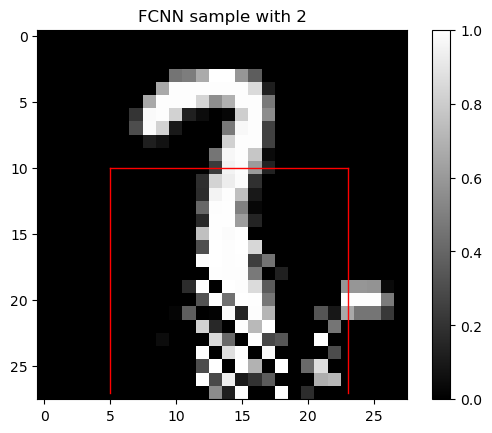

In [134]:
plt.imshow(new_im,cmap='gray')
x = [5, 23]
y = [10, 10]
xx = [5, 5]
yy = [10, 27]
xxx = [23, 23]
yyy = [10, 27]
plt.plot(x, y, color="red", linewidth=1)
plt.plot(xx, yy, color="red", linewidth=1)
plt.plot(xxx, yyy, color="red", linewidth=1)
#plt.savefig('../figures/MNIST_FCNN_sample1.jpg')
plt.title('FCNN sample with 2')
plt.colorbar()

In [116]:
#plt.imshow(mnist_imgs_test[0][1]/255,cmap='gray')

In [203]:
#no sampling
new_im, pred_mu, pred_mu2, pred_sigma2, pred_sigma2_2, pred_pi_mix = gen_im_mix(mlp_mix, mnist_imgs_test[0][11]/255, (5,5))

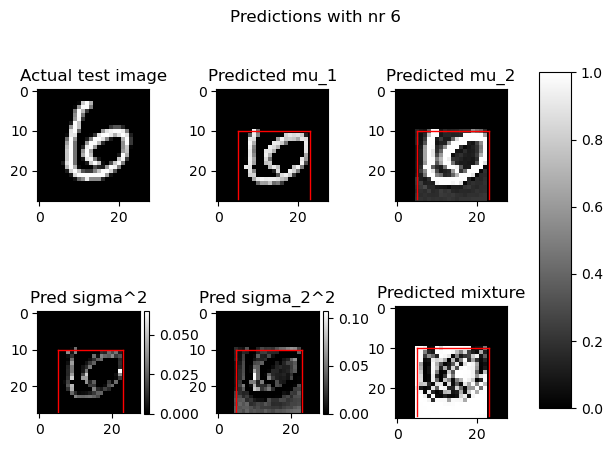

In [205]:
fig, axes = plt.subplots(nrows=2, ncols=3)#,sharex=True, sharey=True)

im = axes.flat[0].imshow(new_im, vmin=0, vmax=1,cmap='gray')
#plt.colorbar(im, ax=axes[0,0],fraction=0.046, pad=0.04)
axes[0,0].set_title("Actual test image")

x = [5, 23]
y = [10, 10]
xx = [5, 5]
yy = [10, 27]
xxx = [23, 23]
yyy = [10, 27]

axes[0,1].plot(x, y, color="red", linewidth=1)
axes[0,1].plot(xx, yy, color="red", linewidth=1)
axes[0,1].plot(xxx, yyy, color="red", linewidth=1)
im = axes.flat[1].imshow(pred_mu, vmin=0, vmax=1,cmap='gray')
#plt.colorbar(im, ax=axes[1],fraction=0.046, pad=0.04)
axes[0,1].set_title("Predicted mu_1")

axes[0,2].plot(x, y, color="red", linewidth=1)
axes[0,2].plot(xx, yy, color="red", linewidth=1)
axes[0,2].plot(xxx, yyy, color="red", linewidth=1)
im = axes.flat[2].imshow(pred_mu2, vmin=0, vmax=1,cmap='gray')
#plt.colorbar(im, ax=axes[1],fraction=0.046, pad=0.04)
axes[0,2].set_title("Predicted mu_2")

axes[1,0].plot(x, y, color="red", linewidth=1)
axes[1,0].plot(xx, yy, color="red", linewidth=1)
axes[1,0].plot(xxx, yyy, color="red", linewidth=1)
im = axes.flat[3].imshow(pred_sigma2,cmap='gray')
#plt.colorbar(im, ax=axes[1,0],fraction=0.046, pad=0.04)
fig.colorbar(im,ax=axes[1,0],fraction=0.046, pad=0.04)
axes[1,0].set_title("Pred sigma^2")

axes[1,1].plot(x, y, color="red", linewidth=1)
axes[1,1].plot(xx, yy, color="red", linewidth=1)
axes[1,1].plot(xxx, yyy, color="red", linewidth=1)
im = axes.flat[4].imshow(pred_sigma2_2, cmap='gray')
fig.colorbar(im, ax=axes[1,1],fraction=0.046, pad=0.04)
#plt.colorbar(im, ax=axes[1,1])#,fraction=0.046, pad=0.04)
axes[1,1].set_title("Pred sigma_2^2")

axes[1,2].plot(x, y, color="red", linewidth=1)
axes[1,2].plot(xx, yy, color="red", linewidth=1)
axes[1,2].plot(xxx, yyy, color="red", linewidth=1)
im = axes.flat[5].imshow(pred_pi_mix, vmin=0, vmax=1,cmap='gray')
axes[1,2].set_title("Predicted mixture")


fig.suptitle('Predictions with nr 6')
#plt.colorbar(im, ax=axes[1],fraction=0.046, pad=0.04)
fig.tight_layout()
#fig.set_figheight(5)
#fig.set_figwidth(10)
#fig.colorbar(im, ax=axes[[0,1],2],fraction=0.46)#, pad=0.04)#fraction=0.46, pad=0.4)# ax=axes.ravel().tolist())
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig('../figures/MNIST_FCNN_pred_res2.jpg')
plt.show()

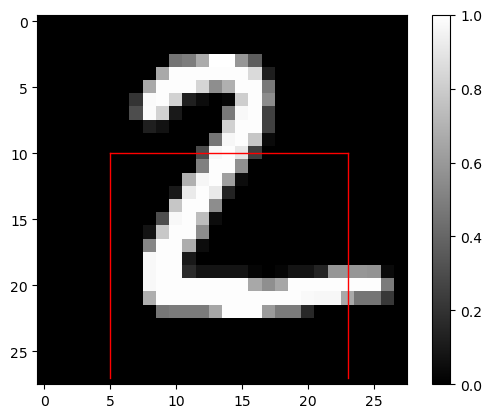

In [137]:
plt.imshow(new_im,cmap='gray')
x = [5, 23]
y = [10, 10]
xx = [5, 5]
yy = [10, 27]
xxx = [23, 23]
yyy = [10, 27]
plt.plot(x, y, color="red", linewidth=1)
plt.plot(xx, yy, color="red", linewidth=1)
plt.plot(xxx, yyy, color="red", linewidth=1)
#plt.savefig('../figures/MNIST_FCNN_sample3.jpg')
plt.colorbar()

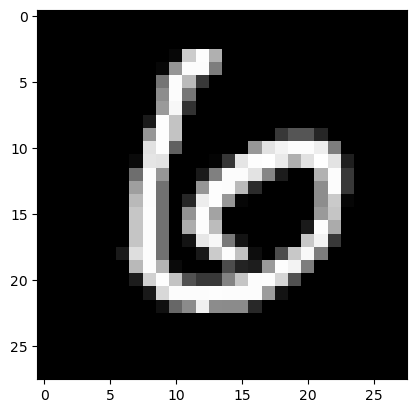

In [202]:
plt.imshow(mnist_imgs_test[0][11]/255,cmap='gray')

In [38]:
mnist_imgs_train = torch.load('digit_MNIST_data/MNIST/processed/training.pt')
mnist_imgs_test = torch.load('digit_MNIST_data/MNIST/processed/test.pt')

In [39]:
#mnist_imgs_train[0][2].shape

torch.Size([28, 28])

In [44]:
#plt.imshow(mnist_imgs_train[0][2]/255,cmap='gray')
#plt.colorbar()

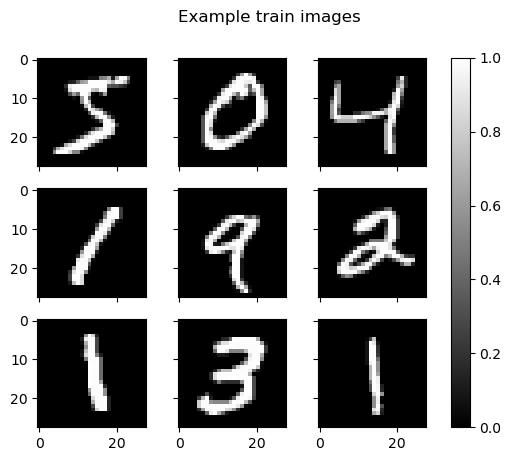

In [43]:
fig, axes = plt.subplots(nrows=3, ncols=3,sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    #print(i,ax)
    im = ax.imshow(mnist_imgs_train[0][i]/255, vmin=0, vmax=1,cmap='gray')

image = fig.colorbar(im, ax=axes.ravel().tolist())
fig.suptitle('Example train images')
plt.savefig('../figures/MNIST_train_im.jpg')#, image)
plt.show()